# Super Vector Machine (SVM)

### Introduction
In this notebook, our objective is to train an SVM (Support Vector Machine) model for a challenging multilabel classification task. This task involves categorizing textual arguments into one or more of 20 distinct categories, each representing a fundamental human value.

The categories are as follows:
- Self-direction: thought
- Self-direction: action
- Stimulation
- Hedonism
- Achievement
- Power: dominance
- Power: resources
- Face
- Security: personal
- Security: societal
- Tradition
- Conformity: rules
- Conformity: interpersonal
- Humility
- Benevolence: caring
- Benevolence: dependability
- Universalism: concern
- Universalism: nature
- Universalism: tolerance
- Universalism: objectivity






### Flow of the notebook


The notebook will be structured into distinct sections to offer a well-organized guide through the implemented process. These sections will include:

1. Installing the required libraries
2. Importing libraries
3. Loading the datasets
4. Preprocessing the data
  - Preprocessing the Arguments
  - Preprocessing the Labels
5. Defining and Fine-Tuning the Model
  - First Config
  - Second Config
6. Evaluation

## Installing the Required Libraries


We have to install the Ray library because it is not be pre-installed in the runtime environment provided by Google Colab.

In [1]:
!pip install ray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 MB 28.3 MB/s eta 0:00:00


In [2]:
!pip install ray[tune]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 2.2 MB/s eta 0:00:00


## Importing Libraries
Here we import the libraries that are essential for executing the project.

In [3]:
import torch

import ray
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler, ASHAScheduler
from ray.tune import CLIReporter

from sklearn.metrics import classification_report

from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report
from sklearn.preprocessing import StandardScaler

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.feature_extraction.text import TfidfVectorizer

import re
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np

from nltk.stem import WordNetLemmatizer

from sklearn.decomposition import TruncatedSVD


## Loading the Data
We utilize data sourced from [Zenodo](https://zenodo.org/record/7550385#.Y8wMquzMK3I), specifically from the [Human Value Detection 2023 competition](https://touche.webis.de/semeval23/touche23-web/index.html). Our focus is on the following datasets: arguments-training.tsv, arguments-validation.tsv, arguments-test.tsv, labels-training.tsv, labels-validation.tsv, and labels-test.tsv.



In [4]:
train_args = pd.read_csv("arguments-training.tsv",delimiter='\t')
train_labels = pd.read_csv("labels-training.tsv",delimiter='\t')

val_labels = pd.read_csv("labels-validation.tsv",delimiter='\t')
val_args = pd.read_csv("arguments-validation.tsv",delimiter='\t')

test_labels = pd.read_csv("labels-test.tsv",delimiter='\t')
test_args = pd.read_csv("arguments-test.tsv",delimiter='\t')

In [5]:
print(train_args.head())

  Argument ID                                   Conclusion       Stance  \
0      A01002                  We should ban human cloning  in favor of   
1      A01005                      We should ban fast food  in favor of   
2      A01006  We should end the use of economic sanctions      against   
3      A01007         We should abolish capital punishment      against   
4      A01008                We should ban factory farming      against   

                                             Premise  
0  we should ban human cloning as it will only ca...  
1  fast food should be banned because it is reall...  
2  sometimes economic sanctions are the only thin...  
3  capital punishment is sometimes the only optio...  
4  factory farming allows for the production of c...  


In [6]:
# we also drip the Conclusion column since it gives redundant information
train_args['Context'] = train_args['Stance'] + " " + train_args['Premise']
train_args.drop(labels=['Argument ID', 'Conclusion', 'Stance', 'Premise'], axis=1, inplace=True)

val_args['Context'] = val_args['Stance'] + " " + val_args['Premise']
val_args.drop(labels=['Argument ID', 'Conclusion', 'Stance', 'Premise'], axis=1, inplace=True)

test_args['Context'] = test_args['Stance'] + " " + test_args['Premise']
test_args.drop(labels=['Argument ID', 'Conclusion', 'Stance', 'Premise'], axis=1, inplace=True)

In [7]:
train_args.head()

,Context
0,in favor of we should ban human cloning as it ...
1,in favor of fast food should be banned because...
2,against sometimes economic sanctions are the o...
3,against capital punishment is sometimes the on...
4,against factory farming allows for the product...


In [8]:
train_labels_compressed = train_labels.drop("Argument ID", axis=1).apply(lambda row: row[row != 0].index.tolist(), axis=1)
val_labels_compressed = val_labels.drop("Argument ID", axis=1).apply(lambda row: row[row != 0].index.tolist(), axis=1)
test_labels_compressed = test_labels.drop("Argument ID", axis=1).apply(lambda row: row[row != 0].index.tolist(), axis=1)

In [9]:
train_labels_compressed.head()

0                                 [Security: societal]
1                                 [Security: personal]
2               [Power: dominance, Security: societal]
3    [Security: societal, Conformity: rules, Univer...
4    [Security: personal, Benevolence: caring, Univ...
dtype: object

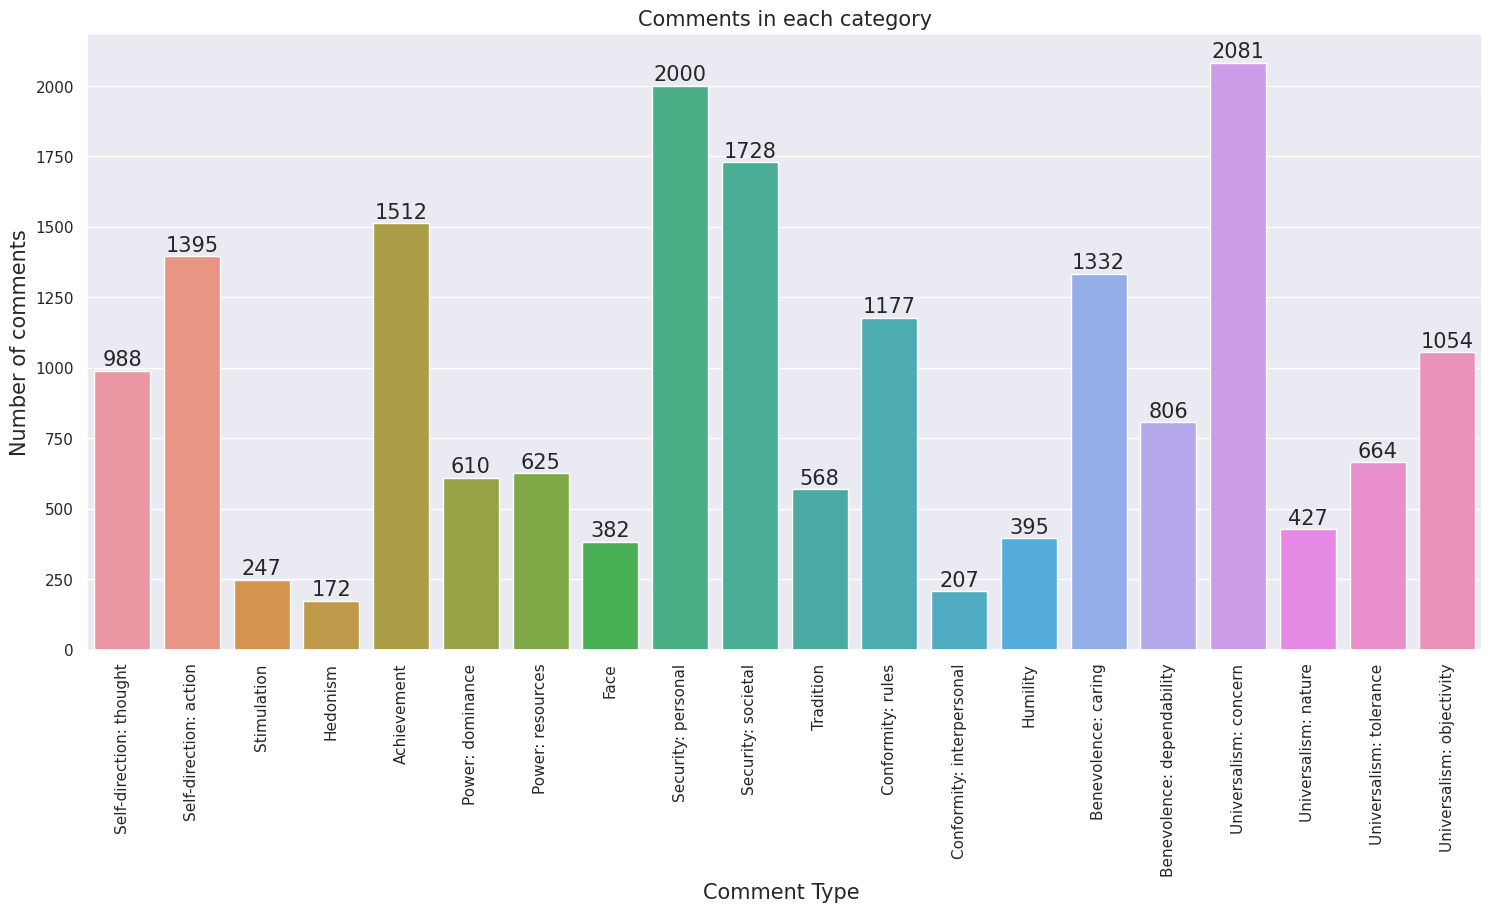

In [10]:
#Counting the number of arguments under each label
categories = list(train_labels.iloc[:,1:].columns.values)
sns.set(font_scale = 1)
plt.figure(figsize=(18,8))
ax= sns.barplot(x = categories, y = train_labels.iloc[:,1:].sum().values)
plt.title("Comments in each category", fontsize=15)
plt.ylabel('Number of comments', fontsize=15)
plt.xlabel('Comment Type ', fontsize=15)
#adding the text labels
rects = ax.patches
labels = train_labels.iloc[:,1:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=15)
# Rotate x-axis labels vertically
plt.xticks(rotation=90)  # You can adjust the rotation angle as needed

plt.show()

## Preprocessing the Data


The preprocessing of arguments and labels is carried out independently.

In [11]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [12]:
# assigning the random seed
np.random.seed(42)

### Preprocessing Arguments

In [13]:
stop_words = set(stopwords.words("english"))

# List of the words having negative meaning
negative_words = {
  'against',
  'ain',
  'aren',
  "aren't",
  'but',
  'couldn',
  "couldn't",
  'didn',
  "didn't",
  'doesn',
  "doesn't",
  'don',
  "don't",
  'hadn',
  "hadn't",
  'hasn',
  "hasn't",
  'haven',
  "haven't",
  'isn',
  "isn't",
  'mightn',
  "mightn't",
  'mustn',
  "mustn't",
  'needn',
  "needn't",
  'no',
  'nor',
  'not',
  'only',
  'shan',
  "shan't",
  'shouldn',
  "shouldn't",
  'too',
  'wasn',
  "wasn't",
  'weren',
  "weren't",
  'won',
  "won't",
  'wouldn',
  "wouldn't"
  }

# Remove negative words from stop_words
stop_words -= negative_words

print(stop_words)

{'has', 'any', 'an', 'under', 'by', 'was', 'about', 'been', 'am', 'just', 'all', 'herself', 'from', 'then', 'further', 'this', 'himself', 't', 'who', 'hers', 'their', 'have', 'off', 'our', 'when', 'once', 'these', 'down', 'into', 'are', 'that', 'doing', "you'd", 'll', 'ours', 'yourself', 'the', "it's", 's', 'now', 'to', 'd', 'of', 'how', 'you', "you're", 'themselves', 'other', 'so', 'those', "you'll", 'again', 'while', 'with', 'and', 'in', 'both', 'being', 'for', 'if', 'before', 'myself', 'where', 'such', 'or', 'o', 'theirs', 'ma', 'she', 'they', 'does', 'his', 're', 'why', 'yourselves', 'your', 'i', 'until', 'above', 'having', 'did', 'her', 'because', 'will', 'itself', 'me', 'each', 'during', 'below', 'there', "she's", 'up', 'through', 'him', 'most', 'yours', 've', 'he', 'than', 'very', 'my', 'ourselves', 'do', 'at', 'y', "that'll", "should've", 'as', 'between', 'm', 'we', 'here', 'which', 'had', 'on', 'be', 'its', "you've", 'few', 'were', 'some', 'after', 'them', 'own', 'out', 'is', 

In [14]:
# Initialize the WordNet lemmatizer
lemmatizer = WordNetLemmatizer()

# function for cleaning the unwanted characters from the data
def clean_text(df):
  all_context = list()
  lines = df["Context"].values.tolist()


  for text in lines:
    text = text.lower()

    # remove all the links
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)

    # replacing all the punctuations
    text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)

    tokens = word_tokenize(text)
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]

    # remove stop words
    words = [w for w in words if not w in stop_words]
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]

    words = ' '.join(words)
    all_context.append(words)

  return all_context

In [15]:
# preprocessing the data
prep_contexts_train = clean_text(train_args)
prep_contexts_val = clean_text(val_args)
prep_contexts_test = clean_text(test_args)

In [16]:
print(prep_contexts_train[1])

favor fast food banned really bad health costly


In [17]:
# Transforming the text into a meaningful representation of numbers
tfidf = TfidfVectorizer(analyzer='word', max_features=1000, ngram_range=(1,7))
X_train = tfidf.fit_transform(prep_contexts_train)
X_val = tfidf.fit_transform(prep_contexts_val)
X_test = tfidf.fit_transform(prep_contexts_test)
X_train.shape

(5393, 1000)

In [18]:
X_train[0]

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 15 stored elements in Compressed Sparse Row format>


### Preprocessing the Labels

In [19]:
from sklearn.preprocessing import MultiLabelBinarizer

In [20]:
# One hot encoding of labels
multilabel = MultiLabelBinarizer()
y_train = multilabel.fit_transform(train_labels_compressed)
y_val = multilabel.fit_transform(val_labels_compressed)
y_test = multilabel.fit_transform(test_labels_compressed)

In [21]:
print(X_val.shape)

(1896, 1000)


In [22]:
y_train[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
target_list = ['Self-direction: thought', 'Self-direction: action', 'Stimulation',
       'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources',
       'Face', 'Security: personal', 'Security: societal', 'Tradition',
       'Conformity: rules', 'Conformity: interpersonal', 'Humility',
       'Benevolence: caring', 'Benevolence: dependability',
       'Universalism: concern', 'Universalism: nature',
       'Universalism: tolerance', 'Universalism: objectivity']

In [24]:
pd.DataFrame(y_train, columns=target_list)

,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,Security: societal,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
4,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5388,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0
5389,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0
5390,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5391,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,1,0


In [25]:
print("shape: ", X_train[:5, :])
print("type: ", type(X_train))
print("shape: ", X_train.shape)

shape:    (0, 138)	0.32445277447065013
  (0, 488)	0.2553710787346946
  (0, 137)	0.32445277447065013
  (0, 351)	0.24763336395158386
  (0, 11)	0.31935264156523435
  (0, 121)	0.2846045357211754
  (0, 490)	0.2922636046843901
  (0, 525)	0.26011396653895363
  (0, 486)	0.28579981846259467
  (0, 177)	0.23221813612368725
  (0, 675)	0.19988060257882856
  (0, 200)	0.24818658701880333
  (0, 487)	0.2048441867575958
  (0, 133)	0.20394357489103404
  (0, 342)	0.07842973295856014
  (1, 375)	0.3738015263453345
  (1, 341)	0.32339954801112686
  (1, 374)	0.3703611244867656
  (1, 475)	0.30942790072275284
  (1, 132)	0.33741088839423394
  (1, 772)	0.37205743066288016
  (1, 139)	0.2781783827214924
  (1, 429)	0.28841804747336797
  (1, 340)	0.3160204316774045
  (1, 342)	0.10031065593140069
  :	:
  (2, 28)	0.1014678423399842
  (2, 675)	0.24006583944673837
  (3, 36)	0.3668868360874177
  (3, 172)	0.30172016777744964
  (3, 35)	0.3668868360874177
  (3, 236)	0.32606501481896044
  (3, 238)	0.33767163299993275
  (3, 533

In [26]:
print("shape: ", y_train[:5, :])
print("type: ", type(y_train))
print("shape: ", y_train.shape)

shape:  [[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0]]
type:  <class 'numpy.ndarray'>
shape:  (5393, 20)


In [27]:
# applying scaler
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.fit_transform(X_val)
X_test_scaled = scaler.fit_transform(X_test)

In [28]:
# Initialize TruncatedSVD
n_components_range = np.arange(1, X_train.shape[1] + 1)
explained_variances = []

In [29]:
# Calculating the cumulative explained variance
for n_components in n_components_range:
    svd = TruncatedSVD(n_components=n_components)
    X_reduced = svd.fit_transform(X_train)
    explained_variances.append(np.sum(svd.explained_variance_ratio_))
    print(f"Computation:{n_components}", np.sum(svd.explained_variance_ratio_))

Computation:1 0.002271175284037763
Computation:2 0.011094263901378049
Computation:3 0.019671082243127424
Computation:4 0.027336447673570394
Computation:5 0.0345472729620488
Computation:6 0.04169018837914696
Computation:7 0.048738757578725776
Computation:8 0.055489580398545464
Computation:9 0.06223574603780443
Computation:10 0.06858989427080046
Computation:11 0.07498826659512185
Computation:12 0.08107487804877388
Computation:13 0.0876240305232005
Computation:14 0.09359926971019138
Computation:15 0.09978372882362743
Computation:16 0.10583625050970635
Computation:17 0.11183498953409839
Computation:18 0.11758295658593176
Computation:19 0.12346836999311313
Computation:20 0.12900344621228302
Computation:21 0.13430134077405123
Computation:22 0.14022568548345174
Computation:23 0.1456289161268182
Computation:24 0.15085954790945288
Computation:25 0.15639454971787134
Computation:26 0.16135893208225047
Computation:27 0.1666791159101345
Computation:28 0.17169561153837415
Computation:29 0.1764937511

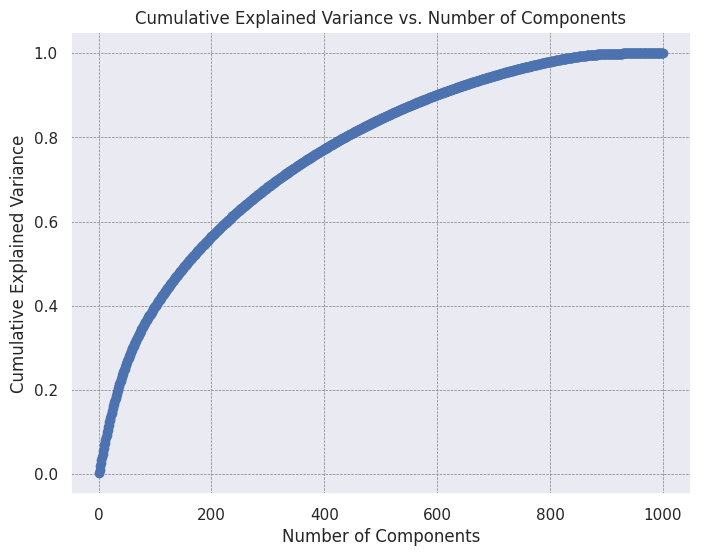

In [30]:
# Plot the cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(n_components_range, explained_variances, marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cumulative Explained Variance vs. Number of Components")
plt.grid(True, linestyle='--', linewidth=0.5, color='gray')
plt.show()



Upon reviewing the plot above and checking the results of the computed cumulative explained variance, it becomes evident that selecting 710 as the number of components results in nearly a 0.95 cumulative explained variance.

In [31]:
# applying dimensionality reduction
svd = TruncatedSVD(710)
X_train_svd = svd.fit_transform(X_train_scaled)
X_val_svd = svd.fit_transform(X_val_scaled)
X_test_svd = svd.fit_transform(X_test_scaled)

print(X_train_svd)

[[ 3.29304296e+00 -2.16668347e+00 -1.52590039e+00 ...  3.91237046e-01
  -2.67345390e-01  4.67685564e-01]
 [ 2.59171428e+00 -1.95658172e+00 -1.25126513e+00 ...  3.10191308e-04
  -3.65830844e-01  3.98198700e-02]
 [ 2.50301422e+00 -2.00029643e+00 -9.34505410e-01 ...  2.44728904e-01
   6.97924929e-01 -1.13174600e+00]
 ...
 [ 2.30702047e+00 -1.71070924e+00 -6.25105265e-01 ... -4.40811213e-01
  -2.92953856e-01  7.36310214e-01]
 [ 2.16380191e+00 -1.68997620e+00 -8.36961473e-01 ...  8.61193029e-01
  -6.38535305e-01  4.87469126e-01]
 [ 2.16591841e+00 -1.49177254e+00 -7.65772604e-01 ...  5.12086553e-01
   2.66165057e-01 -2.04327780e-01]]


## Defining and Fine-Tuning the Model
In this section, we define our model and embark on fine-tuning it by exploring various parameters. We employ the Ray Tune library to experiment with different model configurations. Additionally, we distinguish the polynomial kernels from the RBF and sigmoid kernels, which allows us to train the polynomial kernel with various degrees.

In [32]:
# Initialize Ray and configure resources
ray.init()

2023-09-03 09:06:54,716	INFO worker.py:1621 -- Started a local Ray instance.


Python version:,3.10.12
Ray version:,2.6.3


In [33]:
# Use ASHA scheduler
scheduler = ASHAScheduler(
    time_attr="training_iteration",
    max_t=50,
    grace_period=50,
    metric="f1",
    mode="max"
)

In [34]:
# Use a progress reporter to show intermediate results
reporter = CLIReporter(metric_columns=["f1"])

### First Config
In our second configuration, we train separate sets of parameters for the polynomial kernel with varying degrees.





In [ ]:
# Ray Tune Configuration
config_first = {
    "C": tune.loguniform(2e-3, 2e3),
    "gamma": tune.loguniform(2e-3, 2e3),
    "kernel": tune.choice(["rbf", "sigmoid"])
}

In [ ]:
def objective_first(config):
    C = config["C"]
    gamma = config["gamma"]
    kernel = config["kernel"]

    svc = SVC(C=C, gamma=gamma, kernel=kernel)
    multioutput_svc = MultiOutputClassifier(svc)
    multioutput_svc.fit(X_train_svd, y_train)

    y_pred = multioutput_svc.predict(X_val_svd)
    f1 = f1_score(y_val, y_pred, average='macro')

    # Report the F1 score to Ray Tune
    tune.report(f1=f1, average='macro')


In [ ]:
# Run Ray Tune with the defined configurations
analysis_first = tune.run(
    objective_first,
    config=config_first,
    num_samples=30,
    scheduler=scheduler,
    progress_reporter=reporter
)

2023-09-02 17:09:13,679	INFO tune.py:666 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-09-02 17:09:14,004	WARNING tune.py:997 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+------------------------------------------------------------------------+
| Configuration for experiment     objective_first_2023-09-02_17-09-13   |
+------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                 |
| Scheduler                        AsyncHyperBandScheduler               |
| Number of trials                 30                                    |
+------------------------------------------------------------------------+

View detailed results here: /root/ray_results/objective_first_2023-09-02_17-09-13
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/objective_first_2023-09-02_17-09-13`



2023-09-02 17:09:21,566	WARNING worker.py:2037 -- Warning: The actor ImplicitFunc is very large (81 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Trial status: 16 PENDING
Current time: 2023-09-02 17:09:21. Total running time: 7s
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
+---------------------------------------------------------------------------------+
| Trial name                    status                C          gamma   kernel   |
+---------------------------------------------------------------------------------+
| objective_first_70fb1_00000   PENDING      0.00808081   573.074        rbf      |
| objective_first_70fb1_00001   PENDING      0.0202943     55.5981       sigmoid  |
| objective_first_70fb1_00002   PENDING    232.144          0.00666078   rbf      |
| objective_first_70fb1_00003   PENDING      0.0100242     26.4235       sigmoid  |
| objective_first_70fb1_00004   PENDING     13.0593         0.00952985   rbf      |
| objective_first_70fb1_00005   PENDING      0.00421091     0.896063     rbf      |
| objective_first_70fb1_00006   PENDING     19.77           0.0369721    sigmoid  |
| objective_first_70fb1_00007   

In [ ]:
# Get the best hyperparameters
best_config_first = analysis_first.get_best_config(metric="f1", mode="max")
print("Best Hyperparameters:", best_config_first)

Best Hyperparameters: {'C': 0.2747602509809857, 'gamma': 0.020471419760911644, 'kernel': 'sigmoid'}


In [ ]:
model_first = MultiOutputClassifier(SVC(**best_config_first, class_weight='balanced'))
model_first.fit(X_train_svd, y_train)

MultiOutputClassifier(estimator=SVC(C=0.2747602509809857,
                                    class_weight='balanced',
                                    gamma=0.020471419760911644,
                                    kernel='sigmoid'))

In [ ]:
y_predictions_first = model_first.predict(X_test_svd)

In [ ]:
print(classification_report(y_test, y_predictions_first, target_names = target_list, zero_division=1))

                            precision    recall  f1-score   support

   Self-direction: thought       0.23      0.41      0.29       412
    Self-direction: action       0.21      0.36      0.26       336
               Stimulation       0.10      0.53      0.17       163
                  Hedonism       0.03      0.47      0.06        53
               Achievement       0.18      0.49      0.27       287
          Power: dominance       0.05      0.44      0.08        96
          Power: resources       0.02      0.46      0.03        26
                      Face       0.05      0.51      0.09        74
        Security: personal       0.07      0.58      0.13       108
        Security: societal       0.06      0.49      0.11       105
                 Tradition       0.33      0.41      0.37       537
         Conformity: rules       0.28      0.57      0.38       397
 Conformity: interpersonal       0.21      0.43      0.28       391
                  Humility       0.11      0.56

In [ ]:
f1_first = f1_score(y_test, y_predictions_first, average='macro')
print("Best macro f1 score for the first config", f1_first)

Best macro f1 score for the first config 0.20671550897734522


### Second Config

In [35]:
# Ray Tune Configuration
config_second = {
    "degree": tune.choice([ 2, 3, 4, 5]),
    "C": tune.loguniform(2e-3, 2e3),
    "gamma": tune.loguniform(2e-3, 2e3),
    "kernel": tune.choice(["poly"])
}

In [36]:
def objective_second(config):
    degree = config["degree"]
    C = config["C"]
    gamma = config["gamma"]
    kernel = config["kernel"]

    svc = SVC(degree=degree, C=C, gamma=gamma, kernel=kernel)

    multioutput_svc = MultiOutputClassifier(svc)
    multioutput_svc.fit(X_train_svd, y_train)

    y_pred = multioutput_svc.predict(X_val_svd)
    f1 = f1_score(y_val, y_pred, average='macro')

    # Report the F1 score to Ray Tune
    tune.report(f1=f1, average='macro')


In [37]:
# Run Ray Tune with the defined configurations
analysis_second = tune.run(
    objective_second,
    config=config_second,
    num_samples=30,
    scheduler=scheduler,
    progress_reporter=reporter
)

2023-09-03 09:06:57,963	INFO tune.py:666 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2023-09-03 09:06:58,325	WARNING tune.py:997 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


+-------------------------------------------------------------------------+
| Configuration for experiment     objective_second_2023-09-03_09-06-58   |
+-------------------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator                  |
| Scheduler                        AsyncHyperBandScheduler                |
| Number of trials                 30                                     |
+-------------------------------------------------------------------------+

View detailed results here: /root/ray_results/objective_second_2023-09-03_09-06-58
To visualize your results with TensorBoard, run: `tensorboard --logdir /root/ray_results/objective_second_2023-09-03_09-06-58`



2023-09-03 09:07:06,480	WARNING worker.py:2037 -- Warning: The actor ImplicitFunc is very large (81 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


Streaming output truncated to the last 5000 lines.
| objective_second_3c603_00020   PENDING             4    38.405           3.25381      poly                                             |
| objective_second_3c603_00021   PENDING             5   684.901        1681.6          poly                                             |
| objective_second_3c603_00022   PENDING             2     1.47748       511.953        poly                                             |
| objective_second_3c603_00023   PENDING             3     9.02485        11.7443       poly                                             |
| objective_second_3c603_00024   PENDING             5     0.00246981      0.0155688    poly                                             |
+----------------------------------------------------------------------------------------------------------------------------------------+
3 more RUNNING, 7 more TERMINATED, 5 more PENDING

Trial status: 12 TERMINATED | 8 RUNNING | 10 PENDING
Current tim

2023-09-03 15:24:10,535	WARNING tune.py:192 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


Trial status: 12 TERMINATED | 8 RUNNING | 10 PENDING
Current time: 2023-09-03 15:24:10. Total running time: 6hr 17min 12s
Logical resource usage: 8.0/8 CPUs, 0/0 GPUs
+-----------------------------------------------------------------------------------------------------------------------------------------+
| Trial name                     status         degree              C           gamma   kernel       iter     total time (s)           f1 |
+-----------------------------------------------------------------------------------------------------------------------------------------+
| objective_second_3c603_00001   RUNNING             4     0.00293335     29.7921       poly                                              |
| objective_second_3c603_00003   RUNNING             5     0.00235326      2.98282      poly                                              |
| objective_second_3c603_00006   RUNNING             4    82.5679        198.977        poly                                         

(objective_second pid=12884) Traceback (most recent call last):
(objective_second pid=12884)   File "python/ray/_raylet.pyx", line 1364, in ray._raylet.execute_task.function_executor
(objective_second pid=12884)   File "/usr/local/lib/python3.10/dist-packages/ray/_private/function_manager.py", line 726, in actor_method_executor
2023-09-03 15:24:20,662	WARNING tune.py:1163 -- Experiment has been interrupted, but the most recent state was saved.
Resume experiment with: tune.run(..., resume=True)
2023-09-03 15:24:20,721	WARNING experiment_analysis.py:916 -- Failed to read the results for 18 trials:
- /root/ray_results/objective_second_2023-09-03_09-06-58/objective_second_3c603_00001_1_C=0.0029,degree=4,gamma=29.7921,kernel=poly_2023-09-03_09-07-03
- /root/ray_results/objective_second_2023-09-03_09-06-58/objective_second_3c603_00003_3_C=0.0024,degree=5,gamma=2.9828,kernel=poly_2023-09-03_09-07-03
- /root/ray_results/objective_second_2023-09-03_09-06-58/objective_second_3c603_00006_6_C=82.5

In [38]:
# Get the best hyperparameters
best_config_second = analysis_second.get_best_config(metric="f1", mode="max")
print("Best Hyperparameters:", best_config_second)

Best Hyperparameters: {'degree': 2, 'C': 1.6451403297308647, 'gamma': 0.010947531373230936, 'kernel': 'poly'}


In [39]:
model_second = MultiOutputClassifier(SVC(**best_config_second, class_weight='balanced'))
model_second.fit(X_train_svd, y_train)

MultiOutputClassifier(estimator=SVC(C=1.6451403297308647,
                                    class_weight='balanced', degree=2,
                                    gamma=0.010947531373230936, kernel='poly'))

In [40]:
y_predictions_second = model_second.predict(X_test_svd)

In [ ]:
f1_second = f1_score(y_test, y_predictions_second, average='weighted')
print("f1 score: ", f1_second)

In [42]:
print(classification_report(y_test, y_predictions_second, target_names = target_list, zero_division=1))

                            precision    recall  f1-score   support

   Self-direction: thought       0.28      0.05      0.08       412
    Self-direction: action       0.08      0.01      0.02       336
               Stimulation       0.25      0.01      0.02       163
                  Hedonism       1.00      0.00      0.00        53
               Achievement       0.20      0.02      0.04       287
          Power: dominance       1.00      0.00      0.00        96
          Power: resources       0.00      0.00      0.00        26
                      Face       0.00      0.00      0.00        74
        Security: personal       0.17      0.01      0.02       108
        Security: societal       0.00      0.00      0.00       105
                 Tradition       0.34      0.16      0.22       537
         Conformity: rules       0.24      0.08      0.12       397
 Conformity: interpersonal       0.20      0.02      0.04       391
                  Humility       0.04      0.01

## Evaluation of the model

In [43]:
# Shutdown Ray when finished
ray.shutdown()